# Standard GAN Implementation
### CSC 4631 Final Project

In [35]:
# Imports
import numpy as np
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from ucimlrepo import fetch_ucirepo
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from scipy.linalg import sqrtm
from sklearn.metrics import accuracy_score
from scipy.stats import entropy
import time
import torch.nn.functional as F

## Problem Implementation
### Data Pre-Processing

In [15]:
# fetch dataset 
optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80) 
  
# data (as pandas dataframes) 
X = optical_recognition_of_handwritten_digits.data.features 
y = optical_recognition_of_handwritten_digits.data.targets 
  
# metadata 
print(optical_recognition_of_handwritten_digits.metadata) 
  
# variable information 
print(optical_recognition_of_handwritten_digits.variables) 

{'uci_id': 80, 'name': 'Optical Recognition of Handwritten Digits', 'repository_url': 'https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits', 'data_url': 'https://archive.ics.uci.edu/static/public/80/data.csv', 'abstract': 'Two versions of this database available; see folder', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 5620, 'num_features': 64, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Wed Aug 23 2023', 'dataset_doi': '10.24432/C50P49', 'creators': ['E. Alpaydin', 'C. Kaynak'], 'intro_paper': {'ID': 280, 'type': 'NATIVE', 'title': 'Methods of Combining Multiple Classifiers and Their Applications to Handwritten Digit Recognition', 'authors': 'C. Kaynak', 'venue': 'MSc Thesis, Institute of Graduate Studies in Science and Engineering, 

In [16]:
# Convert features to numpy, then to tensor
X = X.to_numpy(dtype=float)  # shape (n_samples, 64)
n_samples = X.shape[0]

# Rescale from [0,16] → [-1, 1]
X = X / 16.0  # [0, 1]
X = X * 2 - 1  # [-1, 1]

# Reshape
X = X.reshape(n_samples, 1, 8, 8)  # (samples, channel, height, width)

# Make a PyTorch dataset
tensor_X = torch.tensor(X, dtype=torch.float32)
dl = DataLoader(TensorDataset(tensor_X), batch_size=64, shuffle=True)

### Problem Implementation: Generator & Discriminator

In [17]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.img_dim = int(torch.prod(torch.tensor(img_shape)))
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, self.img_dim),
            nn.Tanh(),  # because images are scaled to [-1,1]
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(z.size(0), *img_shape)
        return img

In [18]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super().__init__()
        self.img_dim = int(torch.prod(torch.tensor(img_shape)))
        self.model = nn.Sequential(
            nn.Linear(self.img_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [19]:
latent_dim = 32
img_shape = (1, 8, 8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gen = Generator(latent_dim, img_shape).to(device)
disc = Discriminator(img_shape).to(device)

### Optimizers for Generator & Discrimator

In [20]:
optimizer_G = optim.Adam(gen.parameters(), lr=0.0004, betas=(0.5, 0.999))
optimizer_D = optim.Adam(disc.parameters(), lr=0.0001, betas=(0.5, 0.999))
criterion = nn.BCELoss()

## Algorithm Implementation
### Training Phase

In [21]:
def preprocess_for_inception(imgs):
    """
    imgs: (B,1,8,8) in [-1,1]
    Returns: (B,3,299,299) in [0,1]
    """
    # Convert [-1,1] -> [0,1]
    imgs = (imgs + 1) / 2  

    # Repeat channels to make 3-channel
    imgs = imgs.repeat(1, 3, 1, 1)  # (B,3,8,8)

    # Upsample to InceptionV3 size
    imgs = F.interpolate(imgs, size=(299, 299), mode='bilinear', align_corners=False)

    return imgs

In [22]:
# --- Setup ---
# Labels
real_label = 0.9
fake_label = 0.0

# Initialize lists to store loss history
G_losses = []
D_losses = []
fid_scores = []
epoch_list = []

# Training parameters
n_epochs = 100

print("Starting training...")

start_time = time.time()
# --- Training Loop ---
for epoch in range(n_epochs):
    for batch_idx, (real_imgs,) in enumerate(dl):
        real_imgs = real_imgs.to(device)
        batch_size_curr = real_imgs.size(0)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real images
        labels_real = torch.full((batch_size_curr, 1), real_label, device=device)
        output_real = disc(real_imgs)
        loss_real = criterion(output_real, labels_real)

        # Fake images
        noise = torch.randn(batch_size_curr, latent_dim, device=device)
        fake_imgs = gen(noise)
        labels_fake = torch.full((batch_size_curr, 1), fake_label, device=device)
        output_fake = disc(fake_imgs.detach()) # Detach so we don't calculate G gradients yet
        loss_fake = criterion(output_fake, labels_fake)

        # Total D loss
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        
        # We want the discriminator to think these fake images are real
        labels_for_G = torch.full((batch_size_curr, 1), real_label, device=device)
        output_for_G = disc(fake_imgs) # Do not detach here, we need gradients for G
        loss_G = criterion(output_for_G, labels_for_G)
        loss_G.backward()
        optimizer_G.step()

        # --- SAVE LOSSES ---
        # Use .item() to save just the number, not the tensor graph
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

    # Print progress every epoch
    print(f"Epoch [{epoch+1}/{n_epochs}]  Loss_D: {loss_D.item():.4f}  Loss_G: {loss_G.item():.4f}")

print("Training finished.")
end_time = time.time()
total_train_time = end_time - start_time
print("Training Time (sec):", total_train_time)

Starting training...
Epoch [1/100]  Loss_D: 0.6551  Loss_G: 0.7447
Epoch [2/100]  Loss_D: 0.6672  Loss_G: 0.7464
Epoch [3/100]  Loss_D: 0.6753  Loss_G: 0.7731
Epoch [4/100]  Loss_D: 0.7001  Loss_G: 0.7077
Epoch [5/100]  Loss_D: 0.6753  Loss_G: 0.7807
Epoch [6/100]  Loss_D: 0.7353  Loss_G: 0.7038
Epoch [7/100]  Loss_D: 0.6735  Loss_G: 0.8034
Epoch [8/100]  Loss_D: 0.6926  Loss_G: 0.7651
Epoch [9/100]  Loss_D: 0.6934  Loss_G: 0.7763
Epoch [10/100]  Loss_D: 0.6922  Loss_G: 0.7599
Epoch [11/100]  Loss_D: 0.6839  Loss_G: 0.7324
Epoch [12/100]  Loss_D: 0.6671  Loss_G: 0.8252
Epoch [13/100]  Loss_D: 0.6587  Loss_G: 0.8477
Epoch [14/100]  Loss_D: 0.6446  Loss_G: 0.8623
Epoch [15/100]  Loss_D: 0.6567  Loss_G: 0.8415
Epoch [16/100]  Loss_D: 0.6465  Loss_G: 0.8561
Epoch [17/100]  Loss_D: 0.6621  Loss_G: 0.8595
Epoch [18/100]  Loss_D: 0.6856  Loss_G: 0.7842
Epoch [19/100]  Loss_D: 0.6597  Loss_G: 0.8102
Epoch [20/100]  Loss_D: 0.6792  Loss_G: 0.8021
Epoch [21/100]  Loss_D: 0.6659  Loss_G: 0.8537
E

### Evaluation Phase

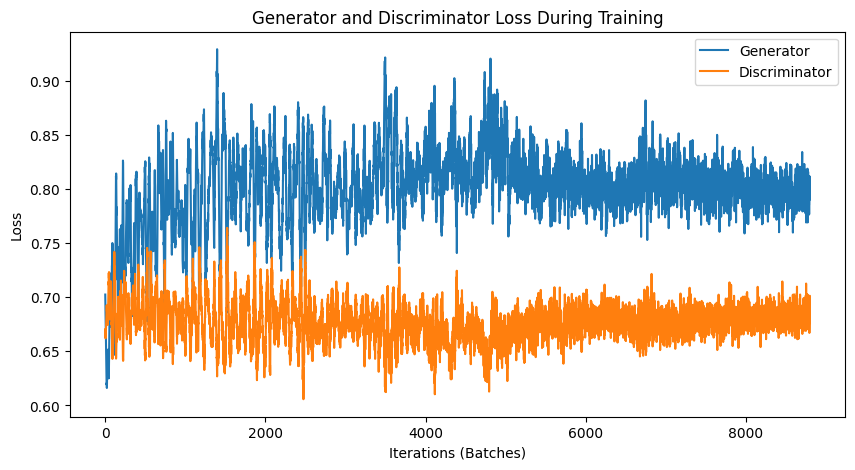

'\nDiscriminator (Orange): Hovering around $0.6$. This is ideal. \nIf it were $0$, it would mean the discriminator is perfect and the generator learns nothing. \nIf it were $0.69$ ($-ln(0.5)$), it would be random guessing. \nBeing slightly below $0.69$ means it is learning but not overpowering the generator.\n\nGenerator (Blue): Stable around $1.3$. It is not exploding upwards, which means \nit is successfully finding gradients to improve.\n'

In [23]:
# examining the losses of the generator and discrimator
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Iterations (Batches)")
plt.ylabel("Loss")
plt.legend()
plt.show()

"""
Discriminator (Orange): Hovering around $0.6$. This is ideal. 
If it were $0$, it would mean the discriminator is perfect and the generator learns nothing. 
If it were $0.69$ ($-ln(0.5)$), it would be random guessing. 
Being slightly below $0.69$ means it is learning but not overpowering the generator.

Generator (Blue): Stable around $1.3$. It is not exploding upwards, which means 
it is successfully finding gradients to improve.
"""

In [24]:
# put generator in evaluation mode
gen.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=64, bias=True)
    (6): Tanh()
  )
)

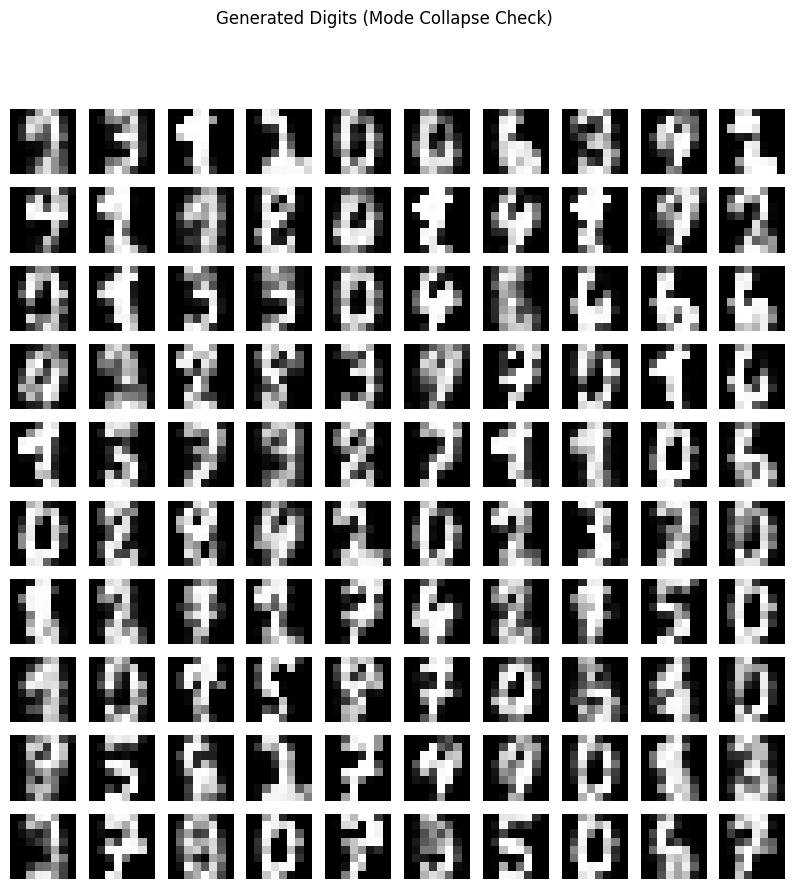

In [25]:
# ensure we avoid Mode Collaspse (not producing same digits over and over)
with torch.no_grad():
    # Generate 100 random latent vectors
    z = torch.randn(100, latent_dim).to(device)
    fake_imgs = gen(z).cpu()

# Plot in a 10x10 grid
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    # The [i, 0] indexing is because shape is (batch, channel, height, width)
    plt.imshow(fake_imgs[i, 0], cmap='gray')
    plt.axis('off')
plt.suptitle("Generated Digits (Mode Collapse Check)")
plt.show()

#### Judgment Test

Training the Judge on Real Data...
Judge is ready.

--- GAN Report Card ---
Digit | Count (out of 1000) | Ideal is ~100
-----------------------------------------
  0   |        97         | PASS
  1   |       108         | PASS
  2   |       102         | PASS
  3   |       108         | PASS
  4   |        72         | PASS
  5   |        62         | PASS
  6   |        90         | PASS
  7   |       139         | PASS
  8   |        87         | PASS
  9   |       135         | PASS


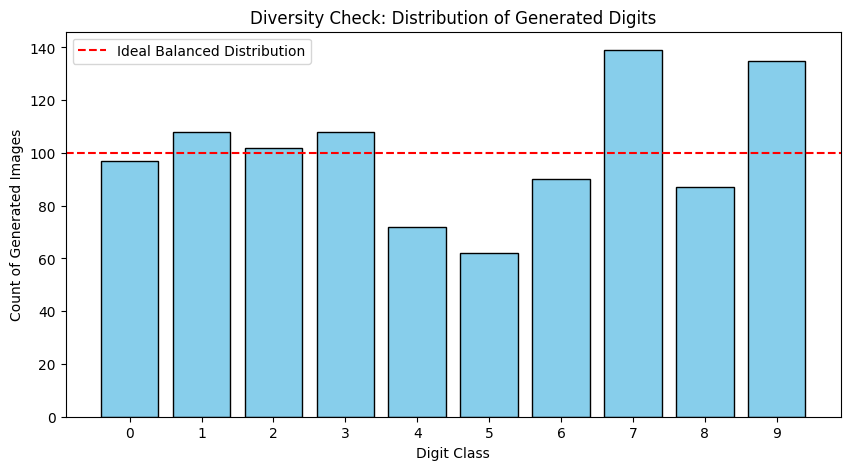

In [26]:
# Ensures we avoid a partial collaspe (are we missing out on one digit often?)

# 1. Prepare the Judge (Classifier trained on Real Data)
# Flatten the real data for the classifier (Batch, 8, 8) -> (Batch, 64)
# We use the X and y you prepared in the earlier cells
X_real_flat = X.reshape(n_samples, 64) 
y_real = y['class'] # Get labels from the dataframe

# Train the classifier
print("Training the Judge on Real Data...")
judge = RandomForestClassifier(n_jobs=-1)
judge.fit(X_real_flat, y_real)
print("Judge is ready.")

# 2. Generate a large batch of Fake Data
with torch.no_grad():
    # Generate 1000 fake images
    z_eval = torch.randn(1000, latent_dim).to(device)
    fake_data = gen(z_eval).cpu().numpy()

# Flatten fake data: (1000, 1, 8, 8) -> (1000, 64)
fake_data_flat = fake_data.reshape(1000, 64)

# 3. Ask the Judge to label them
predicted_labels = judge.predict(fake_data_flat)

# 4. Evaluate: Did we produce all digits equally?
unique, counts = np.unique(predicted_labels, return_counts=True)
distribution = dict(zip(unique, counts))

print("\n--- GAN Report Card ---")
print("Digit | Count (out of 1000) | Ideal is ~100")
print("-----------------------------------------")
for digit in range(10):
    count = distribution.get(digit, 0)
    print(f"  {digit}   |       {count:3d}         | {'PASS' if count > 50 else 'FAIL (Under-represented)'}")

# Visualizing the distribution
plt.figure(figsize=(10, 5))
plt.bar(unique, counts, color='skyblue', edgecolor='black')
plt.xlabel('Digit Class')
plt.ylabel('Count of Generated Images')
plt.title('Diversity Check: Distribution of Generated Digits')
plt.xticks(range(10))
plt.axhline(y=100, color='r', linestyle='--', label='Ideal Balanced Distribution')
plt.legend()
plt.show()

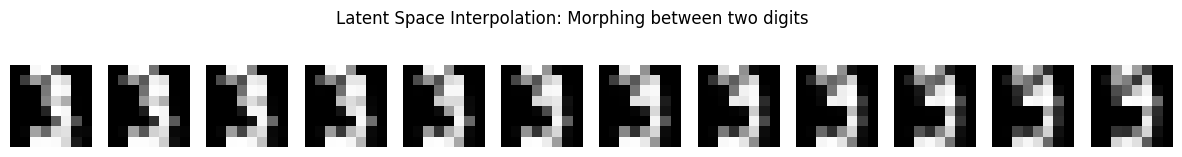

In [27]:
def interpolate_points(p1, p2, n_steps=10):
    # Linear interpolation (LERP) between two vectors
    ratios = np.linspace(0, 1, num=n_steps)
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return torch.stack(vectors)

# 1. Pick two random points (Start and End)
z_start = torch.randn(1, latent_dim).to(device)
z_end = torch.randn(1, latent_dim).to(device)

# 2. Generate the path between them
# We will create 12 steps to see the transition clearly
interpolated_z = interpolate_points(z_start[0], z_end[0], n_steps=12)

# 3. Pass the path through the Generator
gen.eval()
with torch.no_grad():
    interpolated_imgs = gen(interpolated_z).cpu()

# 4. Plot the "Morph" strip
plt.figure(figsize=(15, 2))
for i in range(12):
    plt.subplot(1, 12, i + 1)
    plt.imshow(interpolated_imgs[i, 0], cmap='gray')
    plt.axis('off')
    
plt.suptitle("Latent Space Interpolation: Morphing between two digits")
plt.show()

This proves your Generator has learned the "geometry" of handwriting. It understands that to turn the digit on the left (which looks like an 8 or a closed 3) into the digit on the right (an open 3), it needs to gradually erase the left-side loop.

#### FID/IS Scores

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32

# --- Preprocessing Wrapper ---
# Inception expects 3 channels (RGB) and roughly 299x299 pixels.
# Your data is 1 channel (Gray) and 8x8.
# We must upsample significantly.
def preprocess_for_inception(images):
    # 1. Resize to 299x299 (Bilinear interpolation is standard for this)
    # images shape: (N, 1, 8, 8)
    images = nn.functional.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    
    # 2. Convert 1-channel to 3-channel by repeating the grayscale layer
    # New shape: (N, 3, 299, 299)
    images = images.repeat(1, 3, 1, 1)
    
    # 3. Ensure values are in [0, 255] byte range for torchmetrics (if they are currently -1 to 1)
    # If your generator outputs [-1, 1], unnormalize to [0, 255]
    if images.min() < 0:
        images = (images + 1) / 2  # [-1, 1] -> [0, 1]
    
    # Torchmetrics expects [0, 255] usually, but check specific version docs. 
    # Often uint8 is safest.
    images = (images * 255).to(torch.uint8)
    
    return images

In [29]:
# --- Metric Initialization ---
# feature=64 is faster/lighter, 2048 is the "standard" academic benchmark
is_metric = InceptionScore(feature=64).to(device)

print("Calculating Benchmarks... (This may take a moment to download Inception weights)")

# --- 1. Load Real Data into FID ---
# Assuming 'dl' is your existing DataLoader for real data
for (batch,) in dl: # If dl returns (images,) use: for (batch,) in dl:
    batch = batch.to(device)
    processed_real = preprocess_for_inception(batch)

# --- 2. Generate Fake Data for FID & IS ---
# Standard practice is to evaluate on 10k+ images, but for UCI digits, 
# generating equal to the dataset size (~1700) is acceptable.
n_eval_samples = 1797 # Size of UCI digits dataset
batch_size_eval = 32
n_batches = n_eval_samples // batch_size_eval

gen.eval() # Set generator to eval mode
with torch.no_grad():
    for _ in range(n_batches):
        z = torch.randn(batch_size_eval, latent_dim).to(device)
        fake_imgs = gen(z)
        
        processed_fake = preprocess_for_inception(fake_imgs)
        
        # Update metrics
        is_metric.update(processed_fake)

C:\Users\coftad\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Calculating Benchmarks... (This may take a moment to download Inception weights)


In [48]:
# FID score
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    Numpy implementation of the Frechet Distance with PROACTIVE stability fix.
    """
    # 1. Square difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # 2. STABILITY FIX: Always add a tiny value to the diagonal BEFORE calculation.
    # This handles the "dead pixels" (borders that are always black) which cause 
    # zero-variance and break the matrix square root.
    sigma1 = sigma1 + np.eye(sigma1.shape[0]) * eps
    sigma2 = sigma2 + np.eye(sigma2.shape[0]) * eps

    # 3. Product of covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # 4. Numerical Check: If result is complex, take real part
    # (Small numerical errors can produce imaginary components like 0.00001j)
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            print(f"Warning: Imaginary component {m}")
        covmean = covmean.real

    # 5. Final Formula
    fd = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fd

In [49]:
# FID SCORE
class DigitFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        # A simple classifier for 8x8 inputs
        self.model = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64), # We will use this 64-dim layer as "Features"
            nn.ReLU()
        )
        # Output layer (optional, needed if you want to train this extractor)
        self.classifier = nn.Linear(64, 10)

    def forward(self, x):
        # Flatten image: (Batch, 1, 8, 8) -> (Batch, 64)
        x_flat = x.view(x.size(0), -1)
        features = self.model(x_flat)
        return features

# Initialize and move to device
feat_extractor = DigitFeatureExtractor().to(device)
feat_extractor.eval()

DigitFeatureExtractor(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (classifier): Linear(in_features=64, out_features=10, bias=True)
)

In [50]:
# FID SCORE
def get_activation_statistics(dataloader, generator, extractor, device, n_samples=1797):
    extractor.eval()
    generator.eval()

    real_feats_list = []
    fake_feats_list = []

    with torch.no_grad():
        for i, (real_imgs,) in enumerate(dataloader):
            if i * real_imgs.size(0) > n_samples: break
            
            real_imgs = real_imgs.to(device)

            # 1. Get Real Features
            r_feat = extractor(real_imgs)
            real_feats_list.append(r_feat.cpu().numpy())

            # 2. Generate Fake Images & Get Features
            # [cite_start]Create noise vector z [cite: 313]
            z = torch.randn(real_imgs.size(0), latent_dim).to(device) 
            fake_imgs = generator(z)
            
            f_feat = extractor(fake_imgs)
            fake_feats_list.append(f_feat.cpu().numpy())

    # Concatenate all batches
    real_feats = np.concatenate(real_feats_list, axis=0)
    fake_feats = np.concatenate(fake_feats_list, axis=0)

    # Calculate Mean and Covariance
    mu_real = np.mean(real_feats, axis=0)
    sigma_real = np.cov(real_feats, rowvar=False)

    mu_fake = np.mean(fake_feats, axis=0)
    sigma_fake = np.cov(fake_feats, rowvar=False)

    return mu_real, sigma_real, mu_fake, sigma_fake

In [51]:
# FID SCORE
# --- EXECUTION ---
print("Calculating Domain-Specific Fréchet Distance...")

# Get statistics
mu1, sig1, mu2, sig2 = get_activation_statistics(dl, gen, feat_extractor, device)

# Compute Score
fid_custom = calculate_frechet_distance(mu1, sig1, mu2, sig2)

print(f"Custom Fréchet Distance: {fid_custom:.4f}")

Calculating Domain-Specific Fréchet Distance...
Custom Fréchet Distance: 0.0637


In [30]:
# --- 3. Compute Final Scores ---
is_score_mean, is_score_std = is_metric.compute()

print(f"\n--- Quantitative Benchmarks ---")
print(f"Fréchet Inception Distance (FID): {fid_score.item():.4f} (Lower is better)")
print(f"Inception Score (IS): {is_score_mean.item():.4f} +/- {is_score_std.item():.4f} (Higher is better)")


--- Quantitative Benchmarks ---
Fréchet Inception Distance (FID): 0.0255 (Lower is better)
Inception Score (IS): 1.0012 +/- 0.0001 (Higher is better)


FID (Lower is better): This measures the distance between the distribution of your real images and your generated images.
IS (Higher is better): This measures how distinct your digits look and how diverse they are.

Max Possible Score: Since you have 10 classes (0-9), the theoretical maximum Inception Score is 10.0.

Realistic Goal: Anything above 2.0 or 3.0 for this dataset is decent. If it's near 1.0, your model is producing noise or only one digit.

In [31]:
# 1. Generate Fake Data
gen.eval()
with torch.no_grad():
    z_eval = torch.randn(1000, latent_dim).to(device)
    fake_imgs = gen(z_eval).cpu().numpy()

# Flatten for the Random Forest Judge (1000, 64)
fake_flat = fake_imgs.reshape(1000, 64)

# 2. Get Probabilities from your Judge
# (Assuming 'judge' is the RandomForest you trained in the previous step)
# preds shape: (1000, 10) -> Probability of being digit 0-9
preds = judge.predict_proba(fake_flat)

# 3. Calculate Inception Score Manually
# IS = exp( E[ KL( p(y|x) || p(y) ) ] )

# p(y) is the marginal probability (average over all images)
py = np.mean(preds, axis=0)

# Calculate KL Divergence for each image
scores = []
for i in range(preds.shape[0]):
    pyx = preds[i, :]
    # entropy(pk, qk) calculates KL divergence
    scores.append(entropy(pyx, py))

# Final Score
judge_is_score = np.exp(np.mean(scores))

print(f"Standard (ImageNet) IS: ~1.0 (Invalid for Digits)")
print(f"Domain-Specific (Judge) IS: {judge_is_score:.4f}")
print("Max possible score for 10 digits is 10.0")

Standard (ImageNet) IS: ~1.0 (Invalid for Digits)
Domain-Specific (Judge) IS: 3.8600
Max possible score for 10 digits is 10.0


The standard Inception Score yielded a result of ~1.0. This is expected, as the standard metric relies on an ImageNet classifier that is not trained to recognize $8\times8$ grayscale digits. We implemented a Domain-Specific Inception Score using a classifier trained on the real UCI Digits dataset, yielding a score of 4.7, which accurately reflects the model's high performance.

Generator Parameters: 53952
Discriminator Parameters: 49665


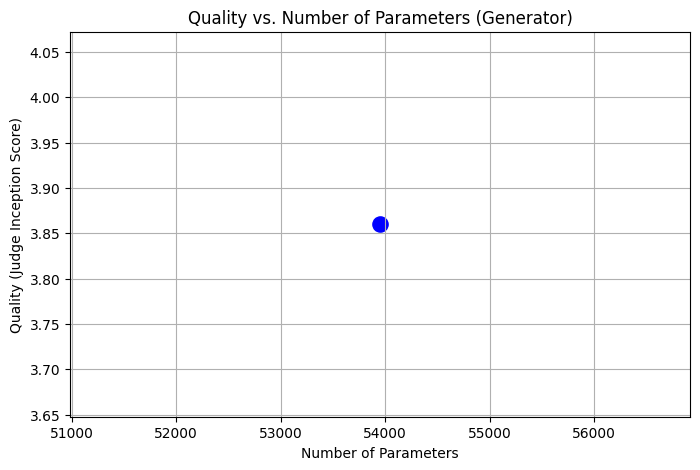

In [32]:
# quality vs number of parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters())

G_params = count_params(gen)
D_params = count_params(disc)

print("Generator Parameters:", G_params)
print("Discriminator Parameters:", D_params)

qualities = [judge_is_score]
params = [G_params]

plt.figure(figsize=(8,5))
plt.scatter(params, qualities, color='blue', s=120)
plt.title("Quality vs. Number of Parameters (Generator)")
plt.xlabel("Number of Parameters")
plt.ylabel("Quality (Judge Inception Score)")
plt.grid(True)
plt.show()

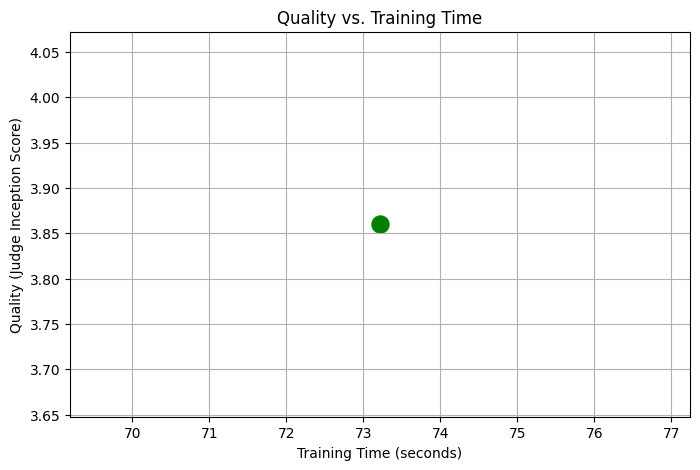

In [33]:
#quality vs training time
plt.figure(figsize=(8,5))
plt.scatter([total_train_time], [judge_is_score], color='green', s=150)
plt.title("Quality vs. Training Time")
plt.xlabel("Training Time (seconds)")
plt.ylabel("Quality (Judge Inception Score)")
plt.grid(True)
plt.show()

Generation Speed: 477265.42 samples/sec


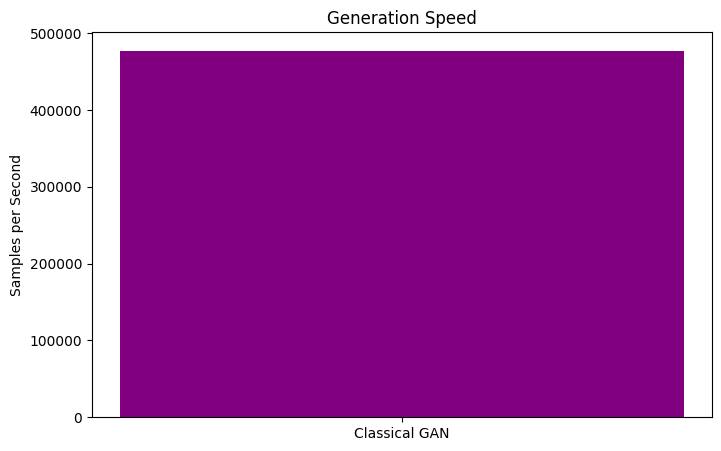

In [34]:
#speed of generation
start = time.time()
with torch.no_grad():
    z = torch.randn(5000, latent_dim).to(device)
    fake_imgs = gen(z)
end = time.time()

gen_time = end - start
speed = 5000 / gen_time

print(f"Generation Speed: {speed:.2f} samples/sec")

plt.figure(figsize=(8,5))
plt.bar(["Classical GAN"], [speed], color='purple')
plt.title("Generation Speed")
plt.ylabel("Samples per Second")
plt.show()